In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import PowerSpectrumPSF

In [3]:
import tqdm

def _get_psf_variation(func, n=20):
    start = 0
    end = start + 225

    fwhm = np.zeros((n, n))
    g1 = np.zeros((n, n))
    g2 = np.zeros((n, n))

    for j, x in tqdm.tqdm(enumerate(np.linspace(start, end, n)), total=n):
        for i, y in enumerate(np.linspace(start, end, n)):
            _psf = func(x, y)
            _psf = _psf.drawImage(scale=0.25, nx=17, ny=17)
            mom = galsim.hsm.FindAdaptiveMom(_psf)
            fwhm[i, j] = mom.moments_sigma * 0.25 * 2.355
            g1[i, j] = mom.observed_shape.g1
            g2[i, j] = mom.observed_shape.g2
    return fwhm, g1, g2

from mdetsims.plots import plot_psf_model

In [7]:
rng = np.random.RandomState(seed=2834)
noise_level = 0
variation_factor = 1
psfs = [
    PowerSpectrumPSF(
        rng=rng,
        im_width=225, buff=75, scale=0.25, trunc=1, 
        noise_level=noise_level,
        variation_factor=variation_factor,
        median_seeing=0.8)
    for i in range(30)]

698018292
736288509
1002768379
265350597
653288082
686345769
353941558
706346907
59242327
949928851
319131170
88444762
1007094710
534049185
63204834
850734670
570808947
114571119
782660883
471934904
458639064
63788795
862809062
34164891
628526724
865955703
205673414
528926676
34357515
338156168


In [ ]:
n = 20
func = lambda x,y: galsim.Sum([psf.getPSF(galsim.PositionD(x=x, y=y)) for psf in psfs])

fwhm, g1, g2 = _get_psf_variation(func, n=n)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
plot_psf_model(fwhm, g1, g2, 225, axs)

 65%|██████▌   | 13/20 [00:21<00:12,  1.74s/it]

100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


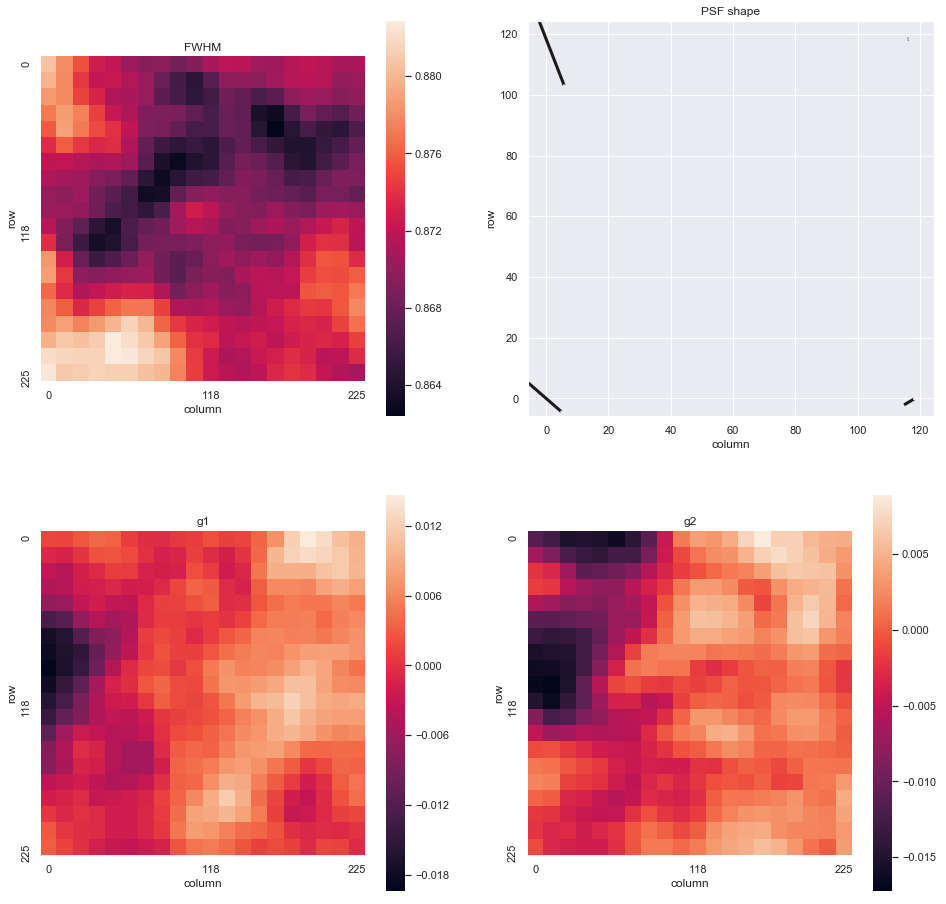

In [8]:
func = lambda x,y: psfs[1].getPSF(galsim.PositionD(x=x, y=y))

n = 20
fwhm, g1, g2 = _get_psf_variation(func, n=n)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
plot_psf_model(fwhm, g1, g2, 225, axs)

100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


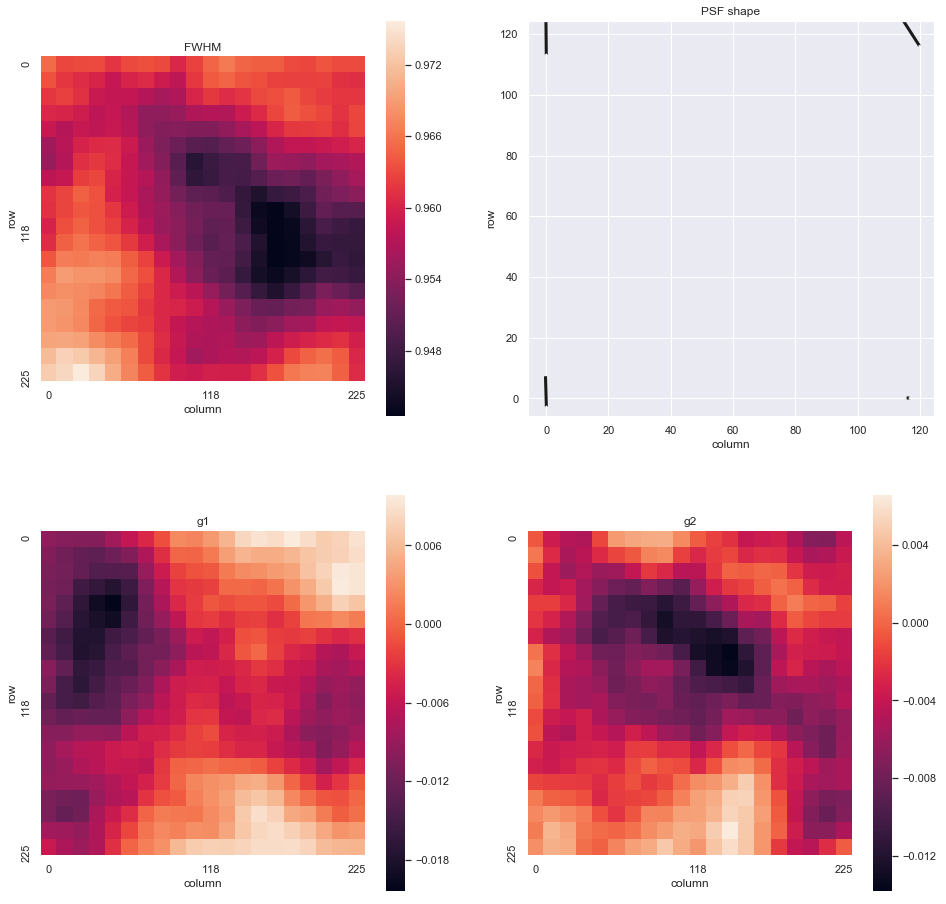

In [9]:
func = lambda x,y: psfs[0].getPSF(galsim.PositionD(x=x, y=y))

n = 20
fwhm, g1, g2 = _get_psf_variation(func, n=n)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
plot_psf_model(fwhm, g1, g2, 225, axs)

In [10]:
import treecorr

y, x = np.mgrid[:20, :20] * 0.263 * 225/20
cat = treecorr.Catalog(
    x=y.ravel(), y=x.ravel(), g1=g1.ravel(), g2=g2.ravel(),
    x_units='arcsec', y_units='arcsec')

gg = treecorr.GGCorrelation(
    nbins=50, min_sep=1, max_sep=60, bin_slop=0.1,
    sep_units='arcsec')

gg.process_auto(cat)
gg.finalize(np.std(g1)**2, np.std(g2)**2)

Text(0.5, 1.0, 'power spectrum PSF')

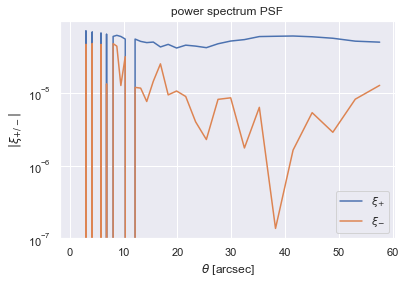

In [11]:
plt.figure()
plt.semilogy(gg.rnom, np.abs(gg.xip), label=r'$\xi_{+}$')
plt.semilogy(gg.rnom, np.abs(gg.xim), label=r'$\xi_{-}$')
plt.xlabel(r'$\theta$ [arcsec]')
plt.ylabel(r'$|\xi_{+/-}|$')
plt.legend(loc=4)
plt.title('power spectrum PSF')

In [ ]:
plt.figure(figsize=(8, 8))
psf_im = psf.getPSF(galsim.PositionD(x=10, y=10)).drawImage(scale=0.25, nx=17, ny=17)
print(psf_im.calculateFWHM())
sns.heatmap(psf_im.array, square=True)